In [1]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch.nn.functional as F

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #Encoder Layers
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 12)
        self.fc3 = nn.Linear(12, 3)
        
        #Decoder Layers
        self.fc4 = nn.Linear(3, 12)
        self.fc5 = nn.Linear(12, 64)
        self.fc6 = nn.Linear(64, 784)

    def forward(self, x):
        #Encoder
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        
        #Decoder
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        return x

# Load MNIST data and apply transformation to reshape input images 
batch_size = 32
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# split data into train and test
test_size = 0.2 # set the size of the test set
train_size = len(mnist_data) - int(test_size*len(mnist_data))
train_data, test_data = random_split(mnist_data, [train_size, int(test_size*len(mnist_data))])

#create data loaders for train and test
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


import torch.nn as nn

class Dense(nn.Module):
    def __init__(self, I, O, f=torch.relu):
        super().__init__()
        self.linear = nn.Linear(I, O)
        self.f = f
    def forward(self, x):
        self.Y = self.linear(x)
        self.Y.retain_grad()
        self.O = self.f(self.Y)
        return self.O
# Create the autoencoder, loss function, and optimizer
model = nn.Sequential(
        Dense(784, 64),
        Dense(64, 12),
        Dense(12, 3),
        Dense(3, 12),
        Dense(12, 64),
        Dense(64, 784, f=torch.sigmoid)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define Custom Loss
class CustomLoss(nn.Module):
    def forward(self, inputs, actual):
        mse = F.mse_loss(inputs, actual)
        mse.backward(create_graph=True)
        std_loss = 0
        for layer in model:
            std_loss += (layer.Y**2).std()
        model.zero_grad()
        return mse, std_loss
    
criterion = CustomLoss()
# Create a SummaryWriter to log information to TensorBoard
writer = SummaryWriter()

# Train the model
num_epochs = 25
for epoch in range(num_epochs):
    running_loss_train = 0.0
    running_loss_test = 0.0
    # train loop
    for data in train_loader:
        images, _ = data
        images = images.view(-1, 784) # reshape input images
        optimizer.zero_grad()
        outputs = model(images)
        loss, std_loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
    # test loop
    for data in test_loader:
        images, _ = data
        images = images.view(-1, 784) # reshape input images
        outputs = model(images)
        loss, std_loss1 = criterion(outputs, images)
        running_loss_test += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss_train/len(train_loader) :.4f}, Test Loss: {running_loss_test/len(test_loader) :.4f}')
    print("Std_loss: ", std_loss.item(), std_loss1.item())
    # Log the training loss and test loss to TensorBoard
    writer.add_scalar('Training Loss', running_loss_train/len(train_loader), epoch + 1)
    writer.add_scalar('Test Loss', running_loss_test/len(test_loader), epoch + 1)

# Close the SummaryWriter
writer.close()


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  ../torch/csrc/autograd/engine.cpp:985.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Epoch [1/25], Training Loss: 0.0611, Test Loss: 0.0534
Std_loss:  352.2608337402344 312.6091003417969
Epoch [2/25], Training Loss: 0.0522, Test Loss: 0.0508
Std_loss:  435.05181884765625 504.47747802734375
Epoch [3/25], Training Loss: 0.0499, Test Loss: 0.0485
Std_loss:  538.6174926757812 750.193603515625
Epoch [4/25], Training Loss: 0.0476, Test Loss: 0.0465
Std_loss:  774.0249633789062 462.48822021484375
Epoch [5/25], Training Loss: 0.0460, Test Loss: 0.0452
Std_loss:  957.4820556640625 859.4749755859375
Epoch [6/25], Training Loss: 0.0449, Test Loss: 0.0443
Std_loss:  1205.8389892578125 1257.3626708984375
Epoch [7/25], Training Loss: 0.0442, Test Loss: 0.0437
Std_loss:  845.4300537109375 1495.211669921875
Epoch [8/25], Training Loss: 0.0435, Test Loss: 0.0430
Std_loss:  1301.1236572265625 1123.640625
Epoch [9/25], Training Loss: 0.0430, Test Loss: 0.0425
Std_loss:  847.2109985351562 1339.576171875
Epoch [10/25], Training Loss: 0.0425, Test Loss: 0.0423
Std_loss:  727.8472290039062 1

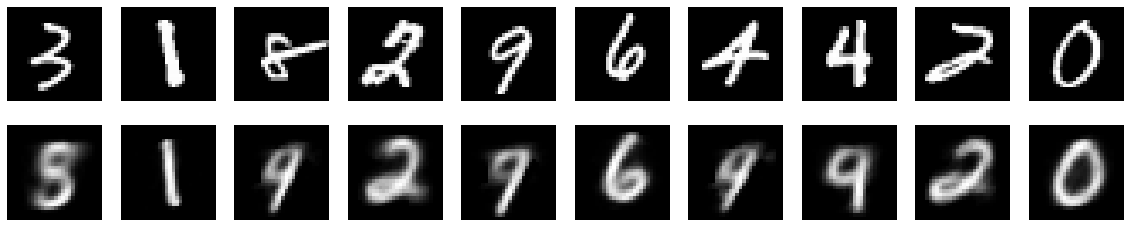

In [2]:
import matplotlib.pyplot as plt

# Select 10 images from the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:10]

# Pass the images through the trained model to get the reconstructions
reconstructed_images = model(images.view(-1, 784))

# Reshape the images and reconstructed images to (28, 28)
images = images.view(-1, 28, 28)
reconstructed_images = reconstructed_images.view(-1, 28, 28)

# Create a figure to display the images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

# Display the original images
for i, ax in enumerate(axes[0, :]):
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

# Display the reconstructed images
for i, ax in enumerate(axes[1, :]):
    ax.imshow(reconstructed_images[i].detach().numpy().squeeze(), cmap='gray')
    ax.axis('off')

# Show the figure
plt.show()


In [3]:
print(train_data[0][0].shape)

torch.Size([1, 28, 28])


In [4]:
#Define custom Dense function



In [5]:
model1 = nn.Sequential(
        Dense(784, 64),
        Dense(64, 12),
        Dense(12, 3),
        Dense(3, 12),
        Dense(12, 64),
        Dense(64, 784, f=torch.sigmoid)
)

In [6]:
# Define custom loss function
import torch.nn.functional as F

class Customloss(nn.Module):
    def forward(self, inputs, actual):
        mse = F.mse_loss(inputs, actual)
        mse.backward(create_graph=True)
        std_loss = 0
        for layer in model1:
            std_loss += (layer.Y**2).std()
        model1.zero_grad()
        return mse, std_loss
    
    
class Customloss1(nn.Module):
    def forward(self, predicted, actual):
        loss = 0
        std = 0
        a = 1e9
        b = 5e11
        mseloss = F.mse_loss(predicted, actual)
        mseloss.backward(create_graph=True)
        
        for layer in model1:
            if isinstance(loss, int):
                loss += torch.mean(layer.Y.grad**2).reshape(1,1)
            else:
                loss = torch.cat((loss, torch.mean(layer.Y.grad**2, dim=0).reshape(1,-1)), dim=1)
            std += (layer.Y.grad**2).std()
        
        dev_loss = b * loss.std()
        model.zero_grad()
        return a * loss.sum(), mseloss, dev_loss, std

In [7]:
# Train the model
criterion = Customloss1()
opt = torch.optim.Adam(model1.parameters(), lr=0.001)

num_epochs = 25
for epoch in range(num_epochs):
    running_loss_train = 0.0
    running_loss_test = 0.0
    # train loop
    for data in train_loader:
        images, _ = data
        images = images.view(-1, 784) # reshape input images
        opt.zero_grad()
        outputs = model1(images)
        Loss, mse, std_loss1, std  = criterion(images, outputs)
        loss = mse + 1e-3 * std_loss1/len(train_loader) + 1e-3 * Loss
        loss.backward()
        opt.step()
        
        
        running_loss_train += mse.item()
    # test loop
    for data in test_loader:
        images, _ = data
        images = images.view(-1, 784) # reshape input images
        outputs = model1(images)
        Loss, mse, std_loss2, std = criterion(images, outputs)
        running_loss_test += mse.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss_train/len(train_loader) :.4f}, Test Loss: {running_loss_test/len(test_loader) :.4f}')
    print("STD_loss: ", std_loss1.item(), std_loss2.item())

Epoch [1/25], Training Loss: 0.0670, Test Loss: 0.0558
STD_loss:  12.104159355163574 10.739635467529297
Epoch [2/25], Training Loss: 0.0546, Test Loss: 0.0529
STD_loss:  11.214592933654785 10.102227210998535
Epoch [3/25], Training Loss: 0.0505, Test Loss: 0.0466
STD_loss:  13.52485466003418 7.443473815917969
Epoch [4/25], Training Loss: 0.0448, Test Loss: 0.0433
STD_loss:  9.557271003723145 10.270976066589355
Epoch [5/25], Training Loss: 0.0428, Test Loss: 0.0420
STD_loss:  9.41831111907959 9.555094718933105
Epoch [6/25], Training Loss: 0.0418, Test Loss: 0.0414
STD_loss:  9.644529342651367 9.073041915893555
Epoch [7/25], Training Loss: 0.0410, Test Loss: 0.0403
STD_loss:  10.012123107910156 9.099104881286621
Epoch [8/25], Training Loss: 0.0403, Test Loss: 0.0399
STD_loss:  9.470836639404297 6.789443492889404
Epoch [9/25], Training Loss: 0.0399, Test Loss: 0.0394
STD_loss:  8.354301452636719 8.402237892150879
Epoch [10/25], Training Loss: 0.0394, Test Loss: 0.0389
STD_loss:  6.59470987

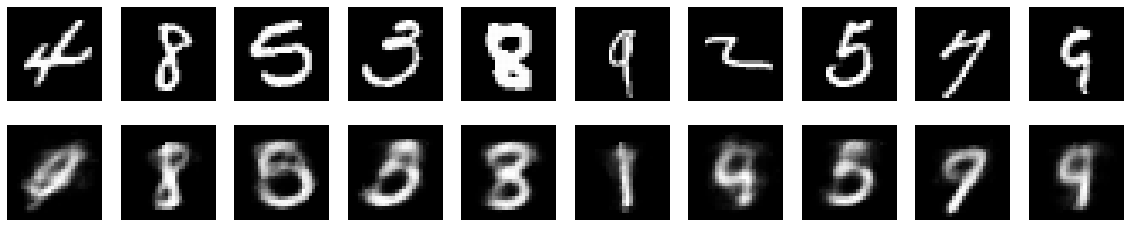

In [8]:
import matplotlib.pyplot as plt

# Select 10 images from the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:10]

# Pass the images through the trained model to get the reconstructions
reconstructed_images = model1(images.view(-1, 784))

# Reshape the images and reconstructed images to (28, 28)
images = images.view(-1, 28, 28)
reconstructed_images = reconstructed_images.view(-1, 28, 28)

# Create a figure to display the images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

# Display the original images
for i, ax in enumerate(axes[0, :]):
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

# Display the reconstructed images
for i, ax in enumerate(axes[1, :]):
    ax.imshow(reconstructed_images[i].detach().numpy().squeeze(), cmap='gray')
    ax.axis('off')

# Show the figure
plt.show()
